### Introduction

The project aims at selecting London's safest borough based on total crimes, mapping the borough's neighbourhoods to find the 10 most common places in each neighborhood and eventually clustering the neighbourhoods using k-mean clustering methodology. 

The study is mainly aimed at people seeking to move to London. Safety is considered as a top concern when moving to a new place to finalize a neighborhood to hunt for an apartment. When people don't feel comfortable at home, then they won't be able to enjoy living there. The data on crime will provide an insight into this problem.

Finally, this project hopefully will solve this problem and could give best location to move to based on several considerations.

### Dataset Used

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [2]:
CLIENT_ID = '0H3FJFHQIQZQ2KF020CLL3JDESN22XJJZPCEZZFQX0PDJT3G'
CLIENT_SECRET = 'PNZQWZSWH4VYZYW21N1352G52Q34V25TT4HSJ0CDQYN1LN30'

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0H3FJFHQIQZQ2KF020CLL3JDESN22XJJZPCEZZFQX0PDJT3G
CLIENT_SECRET:PNZQWZSWH4VYZYW21N1352G52Q34V25TT4HSJ0CDQYN1LN30


### Part 1

Downloading file as dataset
<br> URL: https://www.kaggle.com/jboysen/london-crime?select=london_crime_by_lsoa.csv
<br><br>
Import the dataset using Kaggle API

In [3]:
!kaggle datasets download -d jboysen/london-crime

london-crime.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip 'london-crime.zip' 

Archive:  london-crime.zip
replace london_crime_by_lsoa.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
df = pd.read_csv('london_crime_by_lsoa.csv')

In [4]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


### Part 2 

Preprocessing the data to pandas.dataframe

In [5]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [6]:
df.shape

(392042, 7)

In [7]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [8]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [9]:
london_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
london_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1287            1949   919   
Barnet                       3402            2183   906   
Bexley                       1123            1673   646   
Brent                        2631            2280  2096   
Bromley                      2214            2202   728   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       378     534               5607   
Barnet                                     499     464               9731   
Bexley                                     294     209               4392   
Brent                                      536     919               9026   
Bromley                                    417     369               7584   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        6067  
Barnet                                      7499  
Bexley                                      4503  
Brent                                       9205  
Bromley                                     6650

In [10]:
london_crime.reset_index(inplace = True)

In [11]:
london_crime['Total'] = london_crime.sum(axis=1)
london_crime.head(5)

Borough No_of_Crimes                        \
Major_Category                           Burglary Criminal Damage Drugs   
0               Barking and Dagenham         1287            1949   919   
1                             Barnet         3402            2183   906   
2                             Bexley         1123            1673   646   
3                              Brent         2631            2280  2096   
4                            Bromley         2214            2202   728   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    378     534               5607   
1                                    499     464               9731   
2                                    294     209               4392   
3                                    536     919               9026   
4                                    417     369               7584   

                                            Total  
Major_Category Violence Against the Person         
0                                     6067  16741  
1                                     7499  24684  
2                                     4503  12840  
3                                     9205  26693  
4                                     6650  20164

In [12]:
london_crime.columns = london_crime.columns.map(''.join)
london_crime.head(5)

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [13]:
london_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
london_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [14]:
london_crime.shape

(33, 9)

### Part 3

Scrapping additional information from Wikipedia for the Latitude and Longitude data.

In [15]:
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"a6d2375e-b161-4d0e-bf12-6a0f1cf64a5b","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":958873870,"wgRevisionId":958873870,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of 

In [16]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

In [17]:
london_info = pd.read_html(str(table[0]), index_col=None, header=0)[0]
london_info.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [18]:
# Read in the second table 
london_info1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

london_info1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
london_info1.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [19]:
london_info = london_info.append(london_info1, ignore_index = True) 
london_info.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [20]:
london_info.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [21]:
london_info = london_info.replace('note 1','', regex=True) 
london_info = london_info.replace('note 2','', regex=True) 
london_info = london_info.replace('note 3','', regex=True) 
london_info = london_info.replace('note 4','', regex=True) 
london_info = london_info.replace('note 5','', regex=True) 

# View the top of the data set
london_info

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,Croydon,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
7,Ealing,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
8,Enfield,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
9,Greenwich [],[],Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E,22


In [22]:
set(london_crime.Borough) - set(london_info.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

In [23]:
print("The index of first borough is",london_info.index[london_info['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",london_info.index[london_info['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",london_info.index[london_info['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


In [24]:
london_info.iloc[0,0] = 'Barking and Dagenham'
london_info.iloc[9,0] = 'Greenwich'
london_info.iloc[11,0] = 'Hammersmith and Fulham'

In [25]:
set(london_crime.Borough) - set(london_info.Borough)

set()

### Part 4

Merging the London Crime and London Info table using pd.merge.
<br>This dataframe will be the data used for the analysis.

In [26]:
Ld_crime = pd.merge(london_crime, london_info, on='Borough')
Ld_crime.head(5)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,3402,2183,906,499,464,9731,7499,24684,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,2631,2280,2096,536,919,9026,9205,26693,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,2214,2202,728,417,369,7584,6650,20164,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [27]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,1287,1949,919,378,534,5607,6067,16741
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3402,2183,906,499,464,9731,7499,24684
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12840
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2214,2202,728,417,369,7584,6650,20164


### Methodology

<ul>
    <li><b>Exploratory:</b> Visualize the crime rates in London boroughs to determine the safest borough and remove the borough's neighbourhoods to find the 10 most dangerous places in each neighborhood.</li>
    <li><b>Modelling:</b> To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - mean clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. For this project, we will use a cluster size of 5 to enclose the 15 neighborhoods into 5 clusters. The rationale for doing a K- means clustering is to cluster communities with similar locations together so that people can shortlist their area of interest based on the locations / amenities in each neighborhood.</li>
</ul>

In [28]:
london_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2069.242424,1941.545455,1179.212121,479.060606,682.666667,8913.121212,7041.848485,22306.696970
std,737.448644,625.207070,586.406416,223.298698,441.425366,4620.565054,2513.601551,8828.228749
min,2.000000,2.000000,10.000000,6.000000,4.000000,129.000000,25.000000,178.000000
25%,1531.000000,1650.000000,743.000000,378.000000,377.000000,5919.000000,5936.000000,16903.000000
50%,2071.000000,1989.000000,1063.000000,490.000000,599.000000,8925.000000,7409.000000,22730.000000
75%,2631.000000,2351.000000,1617.000000,551.000000,936.000000,10789.000000,8832.000000,27174.000000
max,3402.000000,3219.000000,2738.000000,1305.000000,1822.000000,27520.000000,10834.000000,48330.000000


In [29]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.2.1


### London's Borough Top 5 Criminals Number

In [36]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5_crime = Ld_crime.head() 
df_top5_crime

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3218,2179,2049,708,1822,27520,10834,48330
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,3087,2764,2738,635,1196,13155,10496,34071
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2946,2621,1838,494,1317,12946,9474,31636
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2115,2496,1684,713,1472,11964,9646,30090
29,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,2794,2357,1629,678,1234,10953,9608,29253


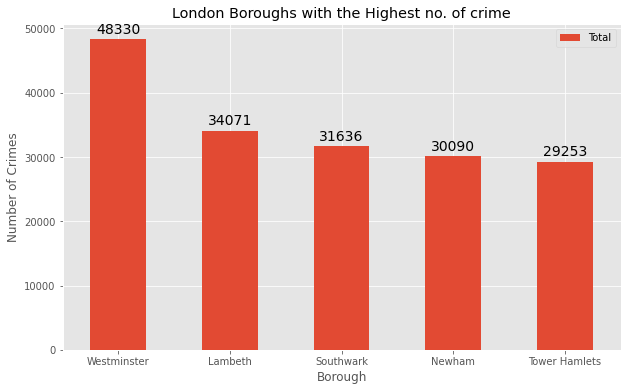

In [37]:
df_total = df_top5_crime[['Borough','Total']]

df_total.set_index('Borough',inplace = True)

ax = df_total.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### London's Borough Least 5 Criminals Number

In [38]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5_crime = Ld_crime.head() 
df_bot5_crime

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,2,2,10,6,4,129,25,178
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,879,1054,743,189,121,3803,3194,9983
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1233,1316,461,253,165,3516,3714,10658
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1359,1148,320,217,106,4769,3155,11074
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,1419,1418,466,249,283,4894,4026,12755


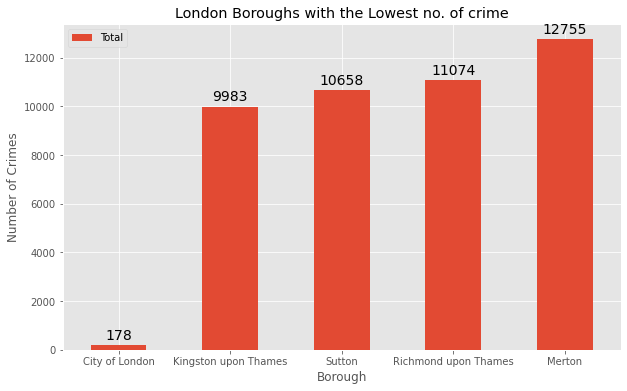

In [39]:
df_total_2 = df_bot5_crime[['Borough','Total']]

df_total_2.set_index('Borough',inplace = True)

ax = df_total_2.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Lowest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

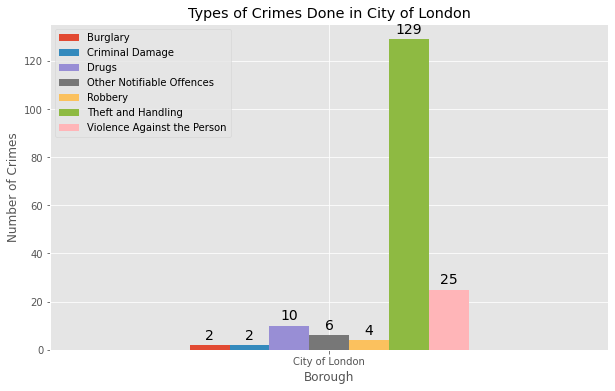

In [40]:
df_bc1 =  df_bot5_crime[df_bot5_crime['Borough'] == 'City of London']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('Types of Crimes Done in City of London') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

As per the wikipedia page, The City of London is the 33rd principal division of Greater London but it is not a London borough. Thus, this study will not focus on City of London and will study more on Kingston upon Thames as the safest borough in London.

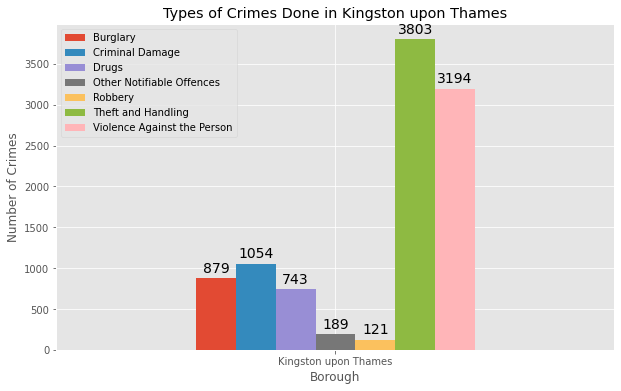

In [41]:
df_bc1 =  df_bot5_crime[df_bot5_crime['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('Types of Crimes Done in Kingston upon Thames') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### Visualizing Map of Kingston upon Thames

In [42]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


In [43]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [44]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


In [46]:
#Berrylands as center of Kingston upon Thames borough

address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


In [48]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

In [49]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [51]:
print(kut_venues.shape)
kut_venues.head()

(174, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Berrylands,51.393781,-0.284802,ExactPrint-UK,51.393288,-0.288874,Print Shop
4,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park


In [52]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,4,4,4,4,4,4
Canbury,14,14,14,14,14,14
Coombe,1,1,1,1,1,1
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,7,7,7,7,7,7


In [53]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 70 uniques categories.


In [54]:
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,Breakfast Spot,Burger Joint,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,Breakfast Spot,Burger Joint,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Canbury,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.071429,0.00,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,Coombe,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Hook,0.000000,0.00,0.250000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Kingston Vale,0.000000,0.00,0.000000,0.250000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,Kingston upon Thames,0.033333,0.00,0.033333,0.000000,0.033333,0.000000,0.00,0.000000,0.066667,...,0.000000,0.00,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.00
6,Malden Rushett,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Motspur Park,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,New Malden,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.00
9,Norbiton,0.000000,0.04,0.000000,0.000000,0.000000,0.000000,0.00,0.040000,0.000000,...,0.000000,0.00,0.040000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.04


In [56]:
kut_grouped.shape

(14, 71)

In [57]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0  Gym / Fitness Center  0.25
1            Print Shop  0.25
2                  Park  0.25
3              Bus Stop  0.25
4     Indian Restaurant  0.00


----Canbury----
                  venue  freq
0                   Pub  0.29
1  Gym / Fitness Center  0.07
2                   Spa  0.07
3                 Plaza  0.07
4     Fish & Chips Shop  0.07


----Coombe----
                       venue  freq
0    Health & Beauty Service   1.0
1           Asian Restaurant   0.0
2  Latin American Restaurant   0.0
3                Pizza Place   0.0
4                   Pharmacy   0.0


----Hook----
               venue  freq
0             Bakery  0.25
1  Indian Restaurant  0.25
2  Fish & Chips Shop  0.25
3        Supermarket  0.25
4   Asian Restaurant  0.00


----Kingston Vale----
              venue  freq
0               Bar  0.25
1     Grocery Store  0.25
2    Sandwich Place  0.25
3      Soccer Field  0.25
4  Asian Restaurant  0.00


----Kingston upon

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Bus Stop,Gym / Fitness Center,Print Shop,Park,Wine Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
1,Canbury,Pub,Park,Gym / Fitness Center,Supermarket,Spa,Shop & Service,Fish & Chips Shop,Plaza,Hotel,Indian Restaurant
2,Coombe,Health & Beauty Service,Wine Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Fried Chicken Joint
3,Hook,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Food
4,Kingston Vale,Sandwich Place,Grocery Store,Bar,Soccer Field,Wine Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


### Clustering

In [60]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 1, 4, 0, 0, 0, 3, 0, 0], dtype=int32)

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,2.0,Bus Stop,Gym / Fitness Center,Print Shop,Park,Wine Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0.0,Pub,Park,Gym / Fitness Center,Supermarket,Spa,Shop & Service,Fish & Chips Shop,Plaza,Hotel,Indian Restaurant
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,1.0,Health & Beauty Service,Wine Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Fried Chicken Joint
4,Hook,Kingston upon Thames,51.367898,-0.307145,4.0,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Food


In [62]:
kut_merged.dropna(inplace = True)
print(kut_merged.shape)

(14, 15)


In [63]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [64]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

### Examining Cluster

#### Cluster 1

In [65]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0,Pub,Park,Gym / Fitness Center,Supermarket,Spa,Shop & Service,Fish & Chips Shop,Plaza,Hotel,Indian Restaurant
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,0,Coffee Shop,Café,Sushi Restaurant,Burger Joint,Pub,Asian Restaurant,Gift Shop,Furniture / Home Store,French Restaurant,Electronics Store
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138,0,Sandwich Place,Grocery Store,Bar,Soccer Field,Wine Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,0,Grocery Store,Pub,Garden Center,Restaurant,Fish & Chips Shop,Department Store,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant
9,New Malden,Kingston upon Thames,51.405335,-0.263407,0,Gym,Gastropub,Bar,Sushi Restaurant,Supermarket,Korean Restaurant,Indian Restaurant,Fish & Chips Shop,Discount Store,Electronics Store
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,0,Food,Indian Restaurant,Italian Restaurant,Platform,Pub,Wine Shop,Rental Car Location,Hardware Store,Hotel,Japanese Restaurant
11,Old Malden,Kingston upon Thames,51.382484,-0.259090,0,Train Station,Food,Construction & Landscaping,Pub,Child Care Service,Indian Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,0,Indian Restaurant,Café,Coffee Shop,Pub,Park,Gym / Fitness Center,Restaurant,Pet Café,Golf Course,Chinese Restaurant
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,0,Coffee Shop,Pub,Pharmacy,Grocery Store,Italian Restaurant,French Restaurant,Train Station,Gym / Fitness Center,Hotel,Farmers Market
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,0,Grocery Store,Pharmacy,Restaurant,Train Station,Hotel,Indian Restaurant,Italian Restaurant,Discount Store,Coffee Shop,Pizza Place


#### Cluster 2

In [66]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.41945,-0.265398,1,Health & Beauty Service,Wine Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Fried Chicken Joint


#### Cluster 3

In [67]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,2,Bus Stop,Gym / Fitness Center,Print Shop,Park,Wine Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


#### Cluster 4

In [68]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,3,Gym,Construction & Landscaping,Park,Soccer Field,Food,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


#### Cluster 5

In [69]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Hook,Kingston upon Thames,51.367898,-0.307145,4,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Food


### Result and Discussion

The goal of this project is to help people who want to move to London's safest borough, expats can select the communities they want to move to based on the most popular locations within it. For example , if a person is looking for a community with a lot of sports centre, we can see that there are gym, park, and soccer field in Clusters 3 and 4. If a person is looking for a neighborhood with a lot of restaurants in close proximity, the 5th cluster is the most appropriate. The rest of them could be examined by looking closely to most common venue to be visited in every cluster.

### Conclusion

This project helps a individual develop a better understanding of the communities as regards the most popular locations in that neighborhood. Making use of technology is also helpful in keeping one step ahead i.e. finding out more about places before moving into a neighborhood. We just took security as a primary concern to shortlist London borough. The future of this project includes taking into account certain considerations, such as the cost of living in the cities, to shortlist the borough based on protection and a predefined budget.